# PROJETO FISCTRANS

Este projeto visa desenvolver uma solução robusta e integrada para monitoramento em tempo real de um caminhão, utilizando uma variedade de sensores e tecnologias de comunicação para coleta, armazenamento e transmissão de dados críticos sobre o veículo.

A arquitetura do sistema é construída em torno da placa ESP32, que se conecta à rede Wi-Fi para enviar dados via MQTT a um servidor remoto, onde as informações podem ser processadas e analisadas. O sistema utiliza sensores como DHT para medir temperatura e umidade, GY-87 para dados de aceleração e giroscópio, MQ-3 para detectar níveis de álcool, e SCT013 para monitoramento de corrente elétrica. Além disso, há uma interface Modbus para leitura de dados de sensores fotovoltaicos e de bateria, e um sistema de monitoramento de pressão e temperatura dos pneus (TPMS).

Os dados são capturados periodicamente e publicados no broker MQTT para visualização e armazenamento, permitindo que gestores monitorem remotamente as condições do veículo. Adicionalmente, o código integra funcionalidades para atualizações de firmware OTA, o que facilita a manutenção e atualização do software sem a necessidade de acesso físico ao dispositivo.

Este projeto também inclui medidas de segurança, como a conexão segura via MQTT e a potencial implementação de certificados de IoT, além de prever uma interface via BLE para configuração inicial do dispositivo, proporcionando flexibilidade no gerenciamento da conectividade do caminhão.

Por fim, o sistema prevê que todos os dados coletados sejam gravados em um cartão SD, garantindo um backup local das informações caso a conexão com o servidor seja interrompida.

## DIAGRAMA FUNCIONAL

In [1]:
import sys
!{sys.executable} -m pip install -U pip --user
!{sys.executable} -m pip install -U codeium-jupyter --user

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U codeium-jupyter

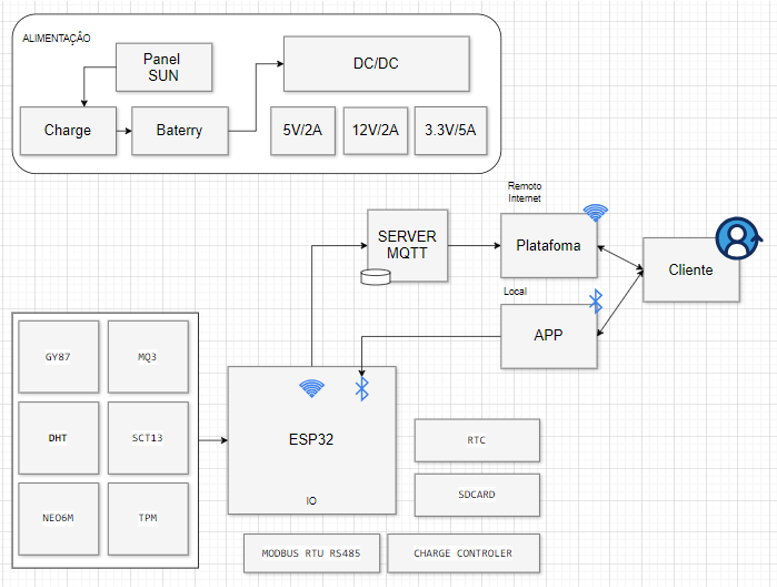

In [118]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "Diagrama.png", width=600, height=6800)

# Código ESP32 BLE + Wifi + MQTT + SDCard

## Importando Bibliotecas

In [29]:
#include <WiFi.h>              // Biblioteca para conexão Wi-Fi
#include <PubSubClient.h>      // Biblioteca para MQTT
#include <DHT.h>               // Biblioteca para sensores DHT
#include <Update.h>            // Biblioteca para atualizações OTA
#include <ArduinoJson.h>       // Biblioteca para manipulação de JSON
#include <ModbusMaster.h>      // Biblioteca para Modbus
#include <TinyGPSPlus.h>  // Inclui a biblioteca TinyGPSPlus
#include <BLEDevice.h>
#include <BLEServer.h>
#include <BLEUtils.h>
#include <BLE2902.h>
#include <SPIFFS.h>
#include <WiFi.h>
#include <PubSubClient.h>      // Biblioteca para MQTT
#include <ArduinoJson.h>       // Biblioteca para processar o JSON


## Configurando Sensores

In [ ]:
TinyGPSPlus gps;  // Cria uma instância do objeto TinyGPSPlus

In [ ]:
DHT dht(DHTPIN, DHTTYPE);         // Inicializa o sensor DHT

## Configurando Servidor MQTT

In [ ]:
// Configurações do MQTT
const char* mqttServer = "broker.emqx.io";        // Endereço do broker MQTT
const int mqttPort = 1883;                         // Porta do broker MQTT
const char* mqttUser = "emqx";                     // Usuário do MQTT
const char* mqttPassword = "public";                // Senha do MQTT

## Define's

In [ ]:
// Definições dos pinos dos sensores
#define DHTPIN 23                // Pino do sensor DHT
#define DHTTYPE DHT22            // Tipo do sensor DHT (DHT22 para AM2301)
#define TRUCK_ID "ABC123"        // ID da placa do caminhão
#define FROTA_ID "TransFiesc"    // ID da frota
#define KWH_COST 0.94            // Custo do kWh em centavos
// Definições dos pinos do NEO-6M
#define GPS_RX_PIN 16  // Pino RX do NEO-6M conectado ao TX do ESP32
#define GPS_TX_PIN 17  // Pino TX do NEO-6M conectado ao RX do ESP32

// Definições dos pinos dos sensores
#define DHTPIN 23                // Pino do sensor DHT
#define DHTTYPE DHT22            // Tipo do sensor DHT (DHT22 para AM2301)
#define TRUCK_ID "ABC123"        // ID da placa do caminhão
#define FROTA_ID "TransFiesc"    // ID da frota
#define KWH_COST 0.94            // Custo do kWh em centavos

## Inicialização

In [ ]:
WiFiClient espClient;             // Cliente Wi-Fi
PubSubClient client(espClient);   // Cliente MQTT
ModbusMaster node;                // Instância do Modbus

In [ ]:
// UUIDs para o serviço e as características BLE
#define SERVICE_UUID        "12345678-1234-5678-1234-56789abcdef0"
#define DHT_CHAR_UUID       "87654321-4321-6789-4321-6789abcdef01"
#define WIFI_CHAR_UUID      "abcd1234-5678-4321-5678-123456789abc"  // UUID para a característica de Wi-Fi

// Variáveis para armazenar temperatura e umidade
float temperature, humidity;

// Função para simular leitura de dados de temperatura e umidade
void simulateDHT() {
    temperature = 20.0 + static_cast<float>(rand()) / (static_cast<float>(RAND_MAX / (30.0 - 20.0)));
    humidity = 40.0 + static_cast<float>(rand()) / (static_cast<float>(RAND_MAX / (60.0 - 40.0)));
    Serial.println("Simulando leitura de DHT...");
}

## SETUP

In [ ]:
void setup() {
    Serial.begin(115200);  // Inicializa a comunicação serial
    dht.begin();           // Inicializa o sensor DHT
    Serial1.begin(9600, SERIAL_8N1, MODBUS_SERIAL_RX, MODBUS_SERIAL_TX); // Configuração da Serial para Modbus
    node.begin(1, Serial1); // ID do dispositivo Modbus (substitua pelo ID correto)

    setupWiFi();           // Conecta ao Wi-Fi
    client.setServer(mqttServer, mqttPort);  // Configura o servidor MQTT
    client.setCallback(callback);             // Define o callback para mensagens MQTT
}

## Chamada de caracterisiticas para escrita do Wifi

In [ ]:
// Função de callback para a característica BLE de Wi-Fi
class WiFiCallbacks: public BLECharacteristicCallbacks {
    void onWrite(BLECharacteristic *pCharacteristic) {
        std::string wifiData = pCharacteristic->getValue();
        Serial.println("Dados de Wi-Fi recebidos via BLE.");

        // Converte os dados recebidos para uma string
        String jsonString = String(wifiData.c_str());
        Serial.println("Dados recebidos: " + jsonString);

        // Usando a biblioteca ArduinoJson para processar o JSON
        DynamicJsonDocument doc(256);
        DeserializationError error = deserializeJson(doc, jsonString);

        if (error) {
            Serial.print("Erro ao processar JSON: ");
            Serial.println(error.c_str());
            return;
        }

        // Extrai o SSID e a senha do JSON
        const char* ssid = doc["ssid"];
        const char* password = doc["password"];

        Serial.println("SSID: " + String(ssid));
        Serial.println("Password: " + String(password));

        // Salva o SSID e a senha no SPIFFS
        if (!SPIFFS.begin(true)) {
            Serial.println("Falha ao inicializar o SPIFFS");
            return;
        }

        File file = SPIFFS.open("/wifi.txt", FILE_WRITE);
        if (!file) {
            Serial.println("Erro ao abrir arquivo para gravação");
            return;
        }

        file.println(ssid);
        file.println(password);
        file.close();
        Serial.println("Dados de Wi-Fi salvos no SPIFFS");

        // Conecta à rede Wi-Fi
        WiFi.begin(ssid, password);
        Serial.print("Conectando à rede Wi-Fi: ");
        Serial.println(ssid);

        // Aguarda a conexão Wi-Fi
        while (WiFi.status() != WL_CONNECTED) {
            delay(500);
            Serial.print(".");
        }

        Serial.println("\nConectado à rede Wi-Fi!");
        Serial.print("Endereço IP: ");
        Serial.println(WiFi.localIP());
    }
};

## Lendo o sensor pro caracteristicas 

In [ ]:
// Função de callback para a característica BLE de DHT
class DHTCallbacks: public BLECharacteristicCallbacks {
    void onRead(BLECharacteristic *pCharacteristic) {
        Serial.println("Iniciando callback de leitura da característica BLE...");
        
        // Simula os dados do sensor DHT
        simulateDHT();

        // Cria uma string JSON com os dados simulados
        String jsonData = String("{\"temperature\":") + temperature + ",\"humidity\":" + humidity + "}";
        Serial.println("Dados simulados do sensor DHT: " + jsonData);

        // Envia os dados para o cliente BLE
        pCharacteristic->setValue(jsonData.c_str());
        Serial.println("Dados enviados para o cliente BLE.");
    }
};

## BLE Status

In [ ]:
// Funções de callback para conexões BLE
class ServerCallbacks: public BLEServerCallbacks {
    void onConnect(BLEServer* pServer) {
        Serial.println("Cliente BLE conectado!");
    }

    void onDisconnect(BLEServer* pServer) {
        Serial.println("Cliente BLE desconectado.");
        // Reinicia a publicidade para permitir novas conexões
        pServer->getAdvertising()->start();
        Serial.println("Reiniciando publicidade BLE.");
    }
};

In [ ]:
void setup() {
    Serial.begin(115200); // Inicia a comunicação serial
    Serial.println("Inicializando...");

    // Inicializa o SPIFFS para armazenar dados
    if (!SPIFFS.begin(true)) {
        Serial.println("Falha ao inicializar o SPIFFS");
        return;
    }

    // Inicializa o BLE
    BLEDevice::init("FiescESP"); // Nome do dispositivo BLE
    Serial.println("Dispositivo BLE inicializado com nome 'FiescESP'");

    BLEServer *pServer = BLEDevice::createServer();
    pServer->setCallbacks(new ServerCallbacks()); // Configura callbacks de conexão/desconexão
    Serial.println("Servidor BLE criado.");

    // Cria um serviço BLE
    BLEService *pService = pServer->createService(SERVICE_UUID);
    Serial.println("Serviço BLE criado com UUID: " + String(SERVICE_UUID));

    // Característica para os dados simulados do sensor DHT
    BLECharacteristic *dhtCharacteristic = pService->createCharacteristic(
                            DHT_CHAR_UUID,
                            BLECharacteristic::PROPERTY_READ
                        );
    dhtCharacteristic->setCallbacks(new DHTCallbacks());

    // Característica para receber dados de Wi-Fi
    BLECharacteristic *wifiCharacteristic = pService->createCharacteristic(
                            WIFI_CHAR_UUID,
                            BLECharacteristic::PROPERTY_WRITE
                        );
    wifiCharacteristic->setCallbacks(new WiFiCallbacks());

    // Adiciona o descritor para a característica DHT
    dhtCharacteristic->addDescriptor(new BLE2902());

    // Inicia o serviço BLE
    pService->start();
    Serial.println("Serviço BLE iniciado.");

    // Inicia a publicidade BLE
    pServer->getAdvertising()->start();
    Serial.println("Esperando conexões BLE...");
}


### Função para fazer a atualização do firmware

In [ ]:
// Função para fazer a atualização do firmware
void updateFirmware(const char* firmwareUrl) {
    String url = String(firmwareUrl);
    int hostEndIndex = url.indexOf('/', 7); // Encontrar o primeiro '/' após "http://"
    String host = url.substring(7, hostEndIndex); // Host sem "http://"
    String path = url.substring(hostEndIndex); // Caminho do arquivo

    // Conectar ao servidor
    WiFiClient client;
    if (client.connect(host.c_str(), 80)) {
        Serial.println("Conectando ao servidor para atualizar o firmware...");

        // Requisição HTTP GET
        client.print(String("GET ") + path + " HTTP/1.1\r\n" +
                     "Host: " + host + "\r\n" +
                     "Connection: close\r\n\r\n");

        // Aguarda a resposta
        while (client.connected() || client.available()) {
            if (client.available()) {
                String line = client.readStringUntil('\n');
                Serial.println(line); // Imprime as linhas da resposta do servidor
                if (line.length() == 0) {
                    break; // Cabeçalho terminado
                }
            }
        }

        // Atualização
        if (Update.begin(client.available())) {
            size_t written = Update.writeStream(client);
            if (written == Update.size()) {
                Serial.println("Atualização concluída com sucesso!");
                Update.end();
                ESP.restart(); // Reinicia o ESP após a atualização
            } else {
                Serial.println("Erro durante a atualização!");
                Update.end();
            }
        } else {
            Serial.println("Falha ao iniciar a atualização!");
        }
    } else {
        Serial.println("Falha na conexão ao servidor.");
    }
}

### Função para ler dados do sensor DHT e publicar no MQTT

In [ ]:
// Função para ler dados do sensor DHT e publicar no MQTT
void readDHTSensor() {
    float humidity = dht.readHumidity();    // Lê a umidade
    float temperature = dht.readTemperature(); // Lê a temperatura em Celsius

    // Verifica se a leitura falhou
    if (isnan(humidity) || isnan(temperature)) {
        Serial.println("Falha ao ler o sensor DHT!");
    } else {
        // Cria um objeto JSON
        DynamicJsonDocument doc(200);
        doc["frota_ID"] = FROTA_ID;  // Adiciona o ID da frota
        doc["truck_id"] = TRUCK_ID;  // Adiciona o ID do caminhão
        doc["humidity"] = humidity;
        doc["temperature"] = temperature;

        // Serializa o objeto JSON para uma string
        String jsonString;
        serializeJson(doc, jsonString);

        // Publica os dados no tópico MQTT
        client.publish("redefrigo/sensor_data", jsonString.c_str());
        
        // Imprime os dados no monitor serial
        Serial.print("Publicando no MQTT: ");
        Serial.println(jsonString);
        // Armazena os dados no cartão SD
        storeDataOnSD("DHTData.txt", jsonString);
    }
}

### Função para ler dados simulados do GY-87

In [ ]:
// Função para ler dados simulados do GY-87
void readGY87Sensors() {
    // Simulação de dados do sensor
    float simulatedPressure = 1013.25 + random(-5, 6); // Simula pressão atmosférica em hPa
    float simulatedAccelX = random(-10, 11) * 0.1;    // Simula aceleração X em g
    float simulatedAccelY = random(-10, 11) * 0.1;    // Simula aceleração Y em g
    float simulatedAccelZ = random(-10, 11) * 0.1;    // Simula aceleração Z em g
    float simulatedGyroX = random(-500, 501) * 0.1;   // Simula giroscópio X em °/s
    float simulatedGyroY = random(-500, 501) * 0.1;   // Simula giroscópio Y em °/s
    float simulatedGyroZ = random(-500, 501) * 0.1;   // Simula giroscópio Z em °/s
    float simulatedMagX = random(-100, 101) * 0.1;    // Simula magnetômetro X em μT
    float simulatedMagY = random(-100, 101) * 0.1;    // Simula magnetômetro Y em μT
    float simulatedMagZ = random(-100, 101) * 0.1;    // Simula magnetômetro Z em μT

    // Cria um objeto JSON para publicação
    DynamicJsonDocument doc(256);
    doc["frota_ID"] = FROTA_ID;  // Adiciona o ID da frota
    doc["truck_id"] = TRUCK_ID;  // Adiciona o ID do caminhão
    doc["pressure"] = simulatedPressure;
    doc["acceleration_x"] = simulatedAccelX;
    doc["acceleration_y"] = simulatedAccelY;
    doc["acceleration_z"] = simulatedAccelZ;
    doc["gyro_x"] = simulatedGyroX;
    doc["gyro_y"] = simulatedGyroY;
    doc["gyro_z"] = simulatedGyroZ;
    doc["magnetic_x"] = simulatedMagX;
    doc["magnetic_y"] = simulatedMagY;
    doc["magnetic_z"] = simulatedMagZ;

    // Serializa e publica
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());
    
    // Imprime os dados no monitor serial
    Serial.print("Publicando no MQTT: ");
    Serial.println(jsonString);
}

### Função para ler dados simulados do sensor MQ-3

In [ ]:
// Função para ler dados simulados do sensor MQ-3
void readMQ3Sensor() {
    // Simulação de dados do sensor MQ-3
    float simulatedAlcoholLevel = random(0, 100) * 0.1; // Simula nível de álcool em mg/L

    // Cria um objeto JSON para publicação
    DynamicJsonDocument doc(200);
    doc["frota_ID"] = FROTA_ID;  // Adiciona o ID da frota
    doc["truck_id"] = TRUCK_ID;  // Adiciona o ID do caminhão
    doc["alcohol_level"] = simulatedAlcoholLevel; // Nível de álcool simulado

    // Serializa e publica
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());
    
    // Imprime os dados no monitor serial
    Serial.print("Publicando no MQTT: ");
    Serial.println(jsonString);
}

### Função para ler dados simulados do sensor SCT013

In [ ]:
void readSCT013Sensor() {
    // Simulação de dados do sensor SCT013
    float simulatedCurrent = random(0, 101) * 0.1; // Simula corrente (0.0 a 10.0 A)
    float simulatedVoltage = 220; // Simula Tensão em Volts
    float simulatedPower = simulatedCurrent * simulatedVoltage; // Potência em Watts

    // Cálculo do consumo em kWh (considerando um intervalo de tempo)
    float timeInHours = 1.0; // Período de medição em horas (ajuste conforme necessário)
    float energyConsumedKWh = (simulatedPower / 1000) * timeInHours; // Consumo em kWh

    // Cálculo do custo da energia
    float cost = energyConsumedKWh * KWH_COST; // Custo em centavos

    // Cria um objeto JSON para publicação
    DynamicJsonDocument doc(200);
    doc["frota_ID"] = FROTA_ID;  // Adiciona o ID da frota
    doc["truck_id"] = TRUCK_ID;   // Adiciona o ID do caminhão
    doc["current"] = simulatedCurrent; // Corrente simulada
    doc["voltage"] = simulatedVoltage;  // Tensão simulada
    doc["power"] = simulatedPower; // Potência simulada
    doc["cost"] = cost; // Custo da energia em centavos

    // Serializa e publica
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());
    
    // Imprime os dados no monitor serial
    Serial.print("Publicando no MQTT: ");
    Serial.println(jsonString);
}

### Função para ler dados do sensor GPS NEO-6M (simulação)

In [ ]:
// Função para ler dados do sensor GPS NEO-6M (simulação)
void readNEO6MSensor() {
    // Simulação de dados do sensor GPS
    float latitude = -23.5505 + random(-10, 11) * 0.0001; // Simula latitude
    float longitude = -46.6333 + random(-10, 11) * 0.0001; // Simula longitude
    float altitude = 760 + random(-10, 11); // Simula altitude em metros

    // Cria um objeto JSON para publicação
    DynamicJsonDocument doc(200);
    doc["frota_ID"] = FROTA_ID;  // Adiciona o ID da frota
    doc["truck_id"] = TRUCK_ID;  // Adiciona o ID do caminhão
    doc["latitude"] = latitude;
    doc["longitude"] = longitude;
    doc["altitude"] = altitude;

    // Serializa e publica
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());
    
    // Imprime os dados no monitor serial
    Serial.print("Publicando dados GPS no MQTT: ");
    Serial.println(jsonString);
}

### Função para ler dados do Modbus

In [ ]:
// Função para ler dados do Modbus
void readModbusData() {
    uint8_t result;
    
    // Endereços a serem lidos
    uint16_t addresses[] = {256, 257, 258, 259, 260};
    float simulatedValues[5];

    // Cria um objeto JSON para publicação
    DynamicJsonDocument doc(256);
    
    for (int i = 0; i < 5; i++) {
        // Simulação dos dados
        simulatedValues[i] = random(0, 100) + random(0, 99) / 100.0; // Gera valores aleatórios de 0.00 a 100.99

        // Envia o pedido de leitura ao dispositivo Modbus
        result = node.readHoldingRegisters(addresses[i], 1); // Lê 1 registro

        if (result == node.ku8MBSuccess) {
            // Supondo que o valor recebido seja uma leitura do Modbus
            uint16_t value = node.getResponseBuffer(0);
            Serial.print("Endereço ");
            Serial.print(addresses[i]);
            Serial.print(": ");
            Serial.print(value);
            Serial.println(" (Valor Modbus)");

            // Adiciona o valor do Modbus ao objeto JSON
            switch (i) {
                case 0: doc["tensao_fotovoltaico"] = value; break;     // Tensão do módulo fotovoltaico
                case 1: doc["corrente_fotovoltaica"] = value; break;   // Corrente fotovoltaica
                case 2: doc["potencia_fotovoltaico"] = value; break;   // Potência fotovoltaica
                case 3: doc["tensao_carga_bateria"] = value; break;    // Tensão carga bateria
                case 4: doc["corrente_carga_bateria"] = value; break;  // Corrente carga bateria
            }
        } else {
            Serial.print("Falha ao ler do endereço ");
            Serial.print(addresses[i]);
            Serial.print(": ");
            Serial.println(result);
        }
    }

    // Simulando a leitura dos dados
    Serial.println("Dados simulados:");
    Serial.print("Tensão do módulo fotovoltaico: ");
    Serial.print(simulatedValues[0]); // Tensão fotovoltaica
    Serial.println(" V");
    Serial.print("Corrente fotovoltaica: ");
    Serial.print(simulatedValues[1]); // Corrente fotovoltaica
    Serial.println(" A");
    Serial.print("Potência fotovoltaica: ");
    Serial.print(simulatedValues[2]); // Potência fotovoltaica
    Serial.println(" W");
    Serial.print("Tensão carga bateria: ");
    Serial.print(simulatedValues[3]); // Tensão carga bateria
    Serial.println(" V");
    Serial.print("Corrente carga bateria: ");
    Serial.print(simulatedValues[4]); // Corrente carga bateria
    Serial.println(" A");

    // Adiciona os dados simulados ao objeto JSON
    doc["tensao_fotovoltaico_simulada"] = simulatedValues[0];
    doc["corrente_fotovoltaica_simulada"] = simulatedValues[1];
    doc["potencia_fotovoltaico_simulada"] = simulatedValues[2];
    doc["tensao_carga_bateria_simulada"] = simulatedValues[3];
    doc["corrente_carga_bateria_simulada"] = simulatedValues[4];

    // Serializa e publica os dados
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());
    
    // Imprime os dados no monitor serial
    Serial.print("Publicando no MQTT: ");
    Serial.println(jsonString);
}Serial.println(result);
        }
    }


### Função para ler dados simulados do TPMS

In [ ]:
// Função para ler dados simulados do TPMS
void readTPMSSensor() {
    // Simulação de dados dos pneus
    DynamicJsonDocument doc(512); // Cria um objeto JSON

    for (int i = 0; i < 8; i++) {
        // Simula pressão (entre 30 e 40 psi) e temperatura (entre 20 e 40 °C)
        float simulatedPressure = random(30, 41) + random(0, 100) / 100.0; // Pressão em psi
        float simulatedTemperature = random(20, 41) + random(0, 100) / 100.0; // Temperatura em °C

        // Adiciona os dados ao objeto JSON
        doc["pneu_" + String(i + 1) + "_pressao"] = simulatedPressure;
        doc["pneu_" + String(i + 1) + "_temperatura"] = simulatedTemperature;

        // Imprime os dados simulados no monitor serial
        Serial.print("Pneu ");
        Serial.print(i + 1);
        Serial.print(" - Pressão: ");
        Serial.print(simulatedPressure);
        Serial.print(" psi, Temperatura: ");
        Serial.print(simulatedTemperature);
        Serial.println(" °C");
    }

    // Serializa e publica os dados
    String jsonString;
    serializeJson(doc, jsonString);
    client.publish("redefrigo/sensor_data", jsonString.c_str());

    // Imprime os dados no monitor serial
    Serial.print("Publicando dados TPMS no MQTT: ");
    Serial.println(jsonString);
}


### Callback para mensagens MQTT

In [ ]:
// Callback para mensagens MQTT
void callback(char* topic, byte* payload, unsigned int length) {
    // Adiciona um terminador nulo ao payload
    payload[length] = '\0'; 

    // Verifica o tópico da mensagem recebida
    if (strcmp(topic, "redefrigo/Resp") == 0) {
        Serial.printf("Mensagem recebida no tópico %s: %s\n", topic, (const char*)payload);

        // Aqui você pode processar a mensagem recebida
        // Exemplo: Controle do TPMS, atualização de parâmetros, etc.
        
        // Se a mensagem for um comando para calibrar os pneus
        if (strcmp((const char*)payload, "calibrar") == 0) {
            // Chame a função que inicia a calibração dos pneus
            Serial.println("Iniciando calibração dos pneus...");
            // adicionar lógica de calibração aqui
        } else {
            Serial.println("Comando desconhecido.");
        }
    }
}

## Armazena dados no cartão SD

In [ ]:

// Função para armazenar dados no cartão SD
void storeDataOnSD(const char* filename, const String& data) {
    File file = SD.open(filename, FILE_APPEND); // Abre o arquivo para escrita
    if (file) {
        file.println(data); // Adiciona os dados ao arquivo
        file.close(); // Fecha o arquivo
        Serial.println("Dados armazenados no cartão SD.");
    } else {
        Serial.println("Erro ao abrir o arquivo para armazenar dados.");
    }
}

In [ ]:
void loop() {
    // O loop pode ser usado para outras tarefas, se necessário
    delay(2000); // Atraso para evitar sobrecarga
    Serial.println("Loop ativo, aguardando conexões BLE...");
    if (!client.connected()) {
        reconnectMQTT();  // Reconecta se não estiver conectado
    }
    
        client.loop();      // Mantém a conexão MQTT viva
        
        // Lê e publica os dados do sensor DHT
        readDHTSensor();
        
        // Lê e publica os dados do GY-87
        readGY87Sensors();
    
        // Lê e publica os dados do sensor MQ-3
        readMQ3Sensor();
    
        // Lê e publica os dados do sensor SCT013
        readSCT013Sensor();
    
        // Lê os dados do Modbus
        readModbusData();
    
        // Lê e publica os dados do TPMS a cada 10 segundos
        readTPMSSensor();
        // Lê e publica os dados do GPS a cada 10 segundos
        readNEO6MSensor();
        delay(10000); // Espera 10 segundos antes da próxima leitura
}

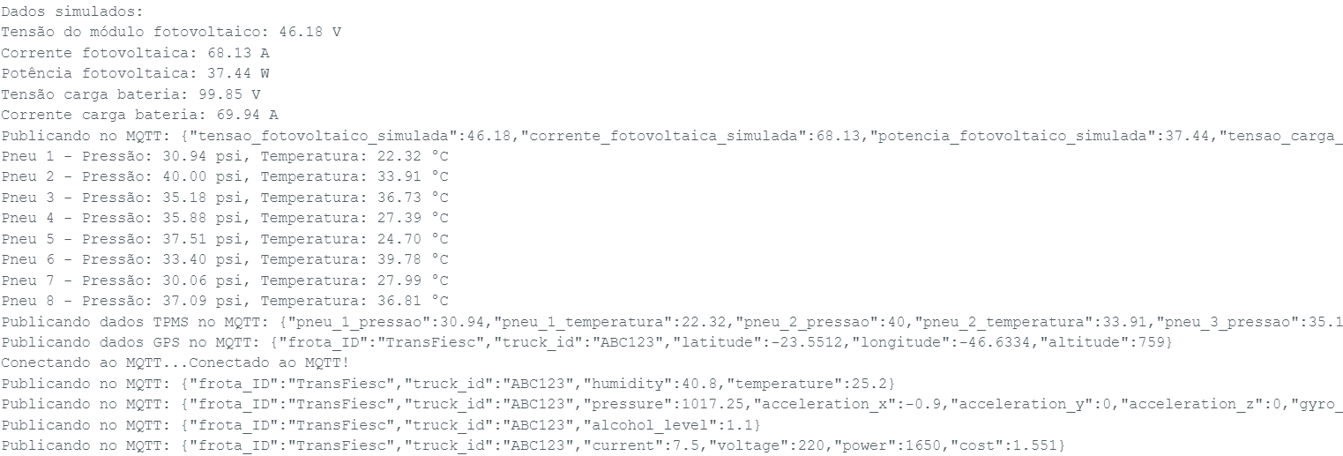

In [111]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "MQTT_Enviado.png", width=800, height=800)

# PLATAFORMA - SERVIDOR

## Servidor WEB

## APP

In [ ]:
import asyncio
import tkinter as tk
from tkinter import messagebox, ttk
from bleak import BleakClient, BleakScanner
import json

# UUIDs do serviço e das características BLE
SERVICE_UUID = "12345678-1234-1234-1234-123456789012"
WIFI_CHAR_UUID = "12345678-1234-1234-1234-123456789013"
SENSOR_CHAR_UUID = "12345678-1234-1234-1234-123456789014"

# Classe da interface gráfica
class WiFiConfigApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Configurar Wi-Fi via BLE")
        self.device = None

        # Campos para SSID e Senha
        self.label_ssid = tk.Label(root, text="SSID:")
        self.label_ssid.grid(row=0, column=0)
        self.entry_ssid = tk.Entry(root)
        self.entry_ssid.grid(row=0, column=1)

        self.label_password = tk.Label(root, text="Senha:")
        self.label_password.grid(row=1, column=0)
        self.entry_password = tk.Entry(root, show="*")
        self.entry_password.grid(row=1, column=1)

        # Campos para Empresa e Placa do caminhão
        self.label_company = tk.Label(root, text="Empresa da Frota:")
        self.label_company.grid(row=2, column=0)
        self.entry_company = tk.Entry(root)
        self.entry_company.grid(row=2, column=1)

        self.label_plate = tk.Label(root, text="Placa do Caminhão:")
        self.label_plate.grid(row=3, column=0)
        self.entry_plate = tk.Entry(root)
        self.entry_plate.grid(row=3, column=1)

        # Combo box para selecionar dispositivos BLE
        self.device_combobox = ttk.Combobox(root)
        self.device_combobox.grid(row=4, column=0, columnspan=2)
        self.device_combobox.set("Selecione um dispositivo BLE")

        # Botões
        self.button_scan = tk.Button(root, text="Procurar Dispositivos", command=self.scan_ble)
        self.button_scan.grid(row=5, column=0, columnspan=2)

        self.button_connect = tk.Button(root, text="Conectar ao BLE", command=self.connect_ble)
        self.button_connect.grid(row=6, column=0, columnspan=2)

        self.button_send = tk.Button(root, text="Enviar Configuração Wi-Fi", command=self.send_credentials)
        self.button_send.grid(row=7, column=0, columnspan=2)

        self.button_receive_data = tk.Button(root, text="Receber Dados do Sensor", command=self.receive_sensor_data)
        self.button_receive_data.grid(row=8, column=0, columnspan=2)

        # Configurar loop para chamada assíncrona do Tkinter
        self.loop = asyncio.get_event_loop()
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

    async def scan_ble(self):
        devices = await BleakScanner.discover()
        self.device_combobox['values'] = [device.name for device in devices if device.name]
        if not self.device_combobox['values']:
            messagebox.showinfo("Nenhum Dispositivo", "Nenhum dispositivo BLE encontrado.")

    async def connect_ble(self):
        selected_device = self.device_combobox.get()
        if selected_device:
            devices = await BleakScanner.discover()
            for device in devices:
                if device.name == selected_device:
                    self.device = await BleakClient(device).connect()
                    messagebox.showinfo("Sucesso", f"Conectado ao {device.name}")
                    return

            messagebox.showerror("Erro", "Não foi possível conectar ao dispositivo selecionado.")
        else:
            messagebox.showerror("Erro", "Por favor, selecione um dispositivo BLE.")

    async def send_credentials(self):
        ssid = self.entry_ssid.get()
        password = self.entry_password.get()
        company = self.entry_company.get()
        plate = self.entry_plate.get()

        if ssid and password and company and plate and self.device:
            # Criar JSON com SSID, senha, empresa e placa
            credentials = {
                "SSID": ssid,
                "Password": password,
                "Company": company,
                "Plate": plate
            }

            # Enviar as credenciais em formato JSON via BLE
            credentials_json = json.dumps(credentials).encode()
            await self.device.write_gatt_char(WIFI_CHAR_UUID, credentials_json)
            messagebox.showinfo("Sucesso", "Credenciais Wi-Fi e informações da frota enviadas com sucesso!")
        else:
            messagebox.showerror("Erro", "Por favor, preencha todos os campos e conecte ao BLE.")

    async def receive_sensor_data(self):
        if self.device:
            # Ler dados da característica do sensor via BLE
            sensor_data = await self.device.read_gatt_char(SENSOR_CHAR_UUID)

            # Decodificar e exibir os dados recebidos (em formato JSON)
            sensor_data_json = sensor_data.decode()
            sensor_data_dict = json.loads(sensor_data_json)

            temperature = sensor_data_dict.get("Temperature", "N/A")
            humidity = sensor_data_dict.get("Humidity", "N/A")

            messagebox.showinfo("Dados do Sensor", f"Temperatura: {temperature}\nUmidade: {humidity}")
        else:
            messagebox.showerror("Erro", "Por favor, conecte-se ao dispositivo BLE antes de tentar receber os dados.")

    def on_closing(self):
        if self.device:
            asyncio.create_task(self.device.disconnect())
        self.root.destroy()

# Função principal para executar a interface
def main():
    root = tk.Tk()
    app = WiFiConfigApp(root)

    # Adicionar métodos assíncronos como callbacks
    app.button_scan.config(command=lambda: asyncio.create_task(app.scan_ble()))
    app.button_connect.config(command=lambda: asyncio.create_task(app.connect_ble()))
    app.button_send.config(command=lambda: asyncio.create_task(app.send_credentials()))
    app.button_receive_data.config(command=lambda: asyncio.create_task(app.receive_sensor_data()))

    # Iniciar o loop de eventos do Tkinter
    root.mainloop()

if __name__ == "__main__":
    main()


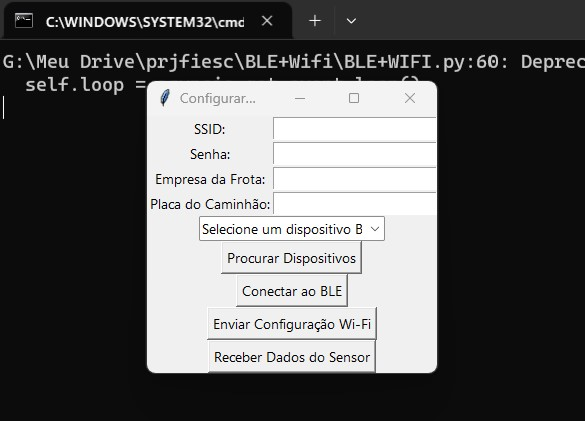

In [90]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "telaApp.jpg", width=400, height=400)

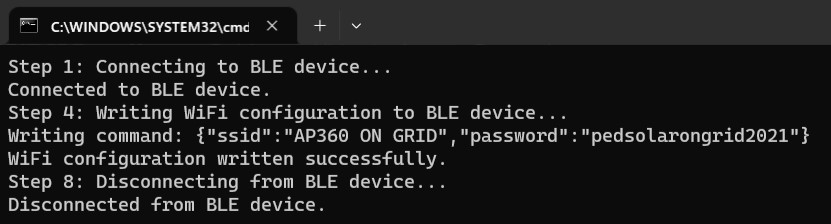

In [3]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "Configura Wifi.jpg", width=400, height=400)

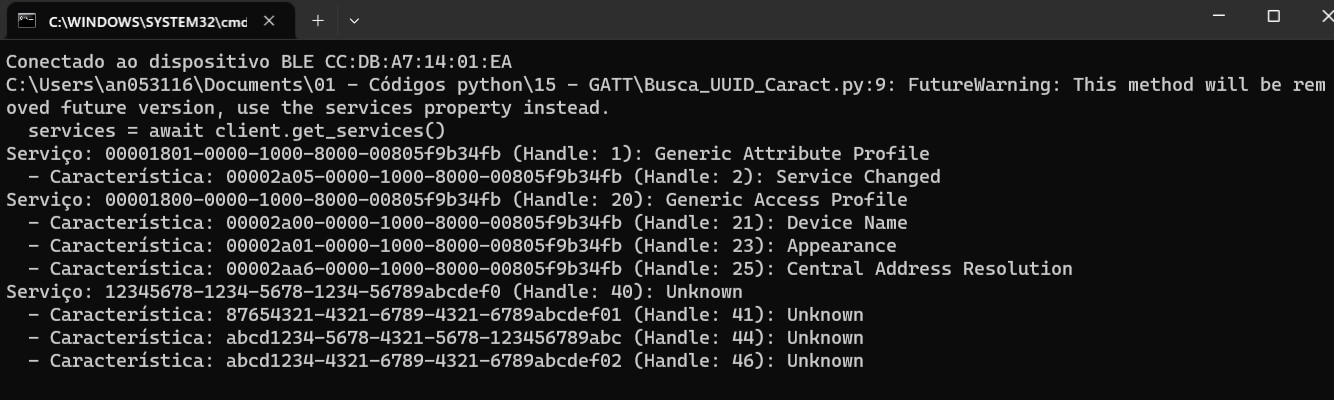

In [1]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "LENDOaSCARACTERISTICAS.jpg", width=400, height=400)

## Código para ler tópico MQTT 

In [ ]:
import random
import time
import json
from paho.mqtt import client as mqtt_client

# Configurações do broker MQTT
broker = 'broker.emqx.io'
port = 1883
topic = "redefrigo/sensor_data"  # Tópico para ler os dados do sensor
client_id = f'python-mqtt-{random.randint(0, 100)}'
username = 'emqx'
password = 'public'

def connect_mqtt() -> mqtt_client:
    """Conecta ao broker MQTT e retorna o cliente."""
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Conectado ao broker MQTT!")
            client.subscribe(topic)  # Inscreve no tópico
        else:
            print(f"Falha na conexão, código de retorno: {rc}")

    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.on_message = on_message  # Define a função de callback para mensagens recebidas
    client.connect(broker, port)
    return client

def on_message(client, userdata, msg):
    """Callback para mensagens recebidas."""
    try:
        # Decodifica a mensagem recebida
        message = msg.payload.decode()
        # Carrega a mensagem JSON
        data = json.loads(message)
        # Imprime os dados
        print(f"Mensagem recebida no tópico '{msg.topic}': {data}")
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar a mensagem JSON: {e}")

def run():
    client = connect_mqtt()
    client.loop_start()  # Inicia o loop para manter a conexão

    try:
        while True:
            time.sleep(1)  # Aguarda novas mensagens
    except KeyboardInterrupt:
        print("Encerrando o cliente MQTT...")
    finally:
        client.loop_stop()  # Para o loop
        client.disconnect()  # Desconecta do broker

if __name__ == '__main__':
    run()


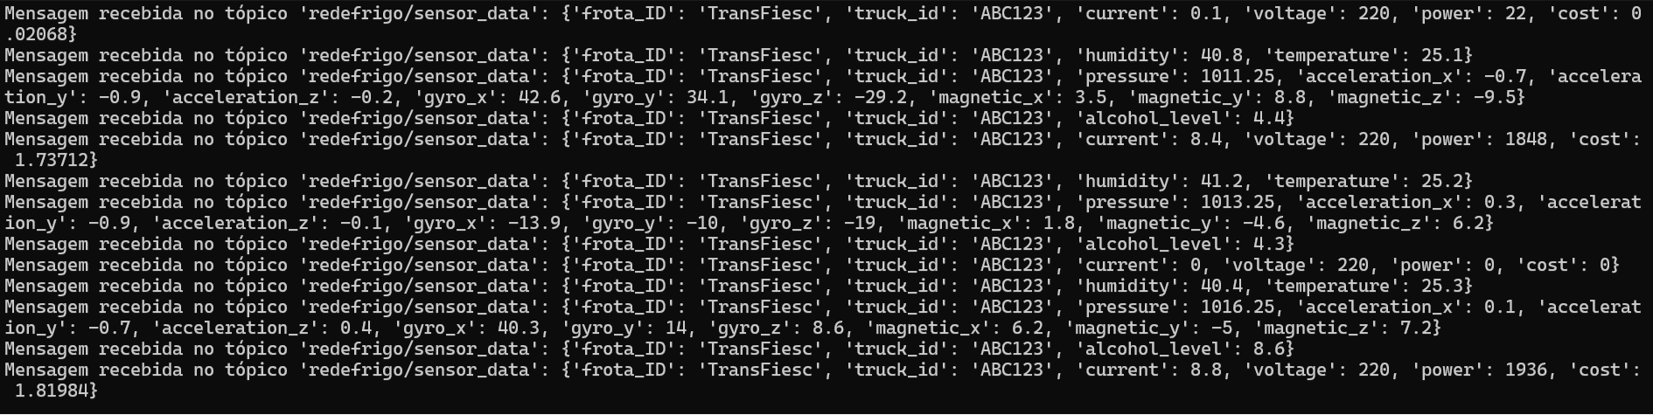

In [96]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "MQTT_recebe.png", width=800, height=800)

### Atualização do Firwamre Via Servidor

In [ ]:
import random
import time
from paho.mqtt import client as mqtt_client

broker = 'broker.emqx.io'  # Endereço do broker MQTT
port = 1883                  # Porta do broker MQTT
topic = "redefrigo/firmware"  # Tópico para enviar a URL do firmware
client_id = f'python-mqtt-{random.randint(0, 100)}'
username = 'emqx'           # Usuário do MQTT
password = 'public'         # Senha do MQTT

def connect_mqtt() -> mqtt_client:
    """Conecta ao broker MQTT e retorna o cliente."""
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Conectado ao broker MQTT!")
        else:
            print(f"Falha na conexão, código de retorno: {rc}")

    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

def publish_firmware_url(client: mqtt_client, firmware_url: str):
    """Publica a URL do firmware no tópico definido."""
    result = client.publish(topic, firmware_url)
    status = result[0]
    if status == 0:
        print(f"Mensagem enviada para o tópico '{topic}': {firmware_url}")
    else:
        print(f"Falha ao enviar mensagem para o tópico '{topic}'")

def run():
    client = connect_mqtt()
    client.loop_start()  # Inicia o loop para manter a conexão

    # Substitua pela URL do firmware que deseja enviar
    firmware_url = "https://drive.google.com/file/d/13qjx3YfCWQ3lZBaznzplG5AMXG2qZLCM/view?usp=drive_link/CodigoFiesc.ino.bin"  # Altere para uma URL acessível
    # Exemplo de URL local (apenas para testes): firmware_url = "http://localhost:8000/firmware.bin"

    try:
        while True:
            publish_firmware_url(client, firmware_url)  # Publica a URL do firmware
            time.sleep(10)  # Espera 10 segundos antes de enviar novamente
    except KeyboardInterrupt:
        print("Encerrando o cliente MQTT...")
    finally:
        client.loop_stop()  # Para o loop
        client.disconnect()  # Desconecta do broker

if __name__ == '__main__':
    run()


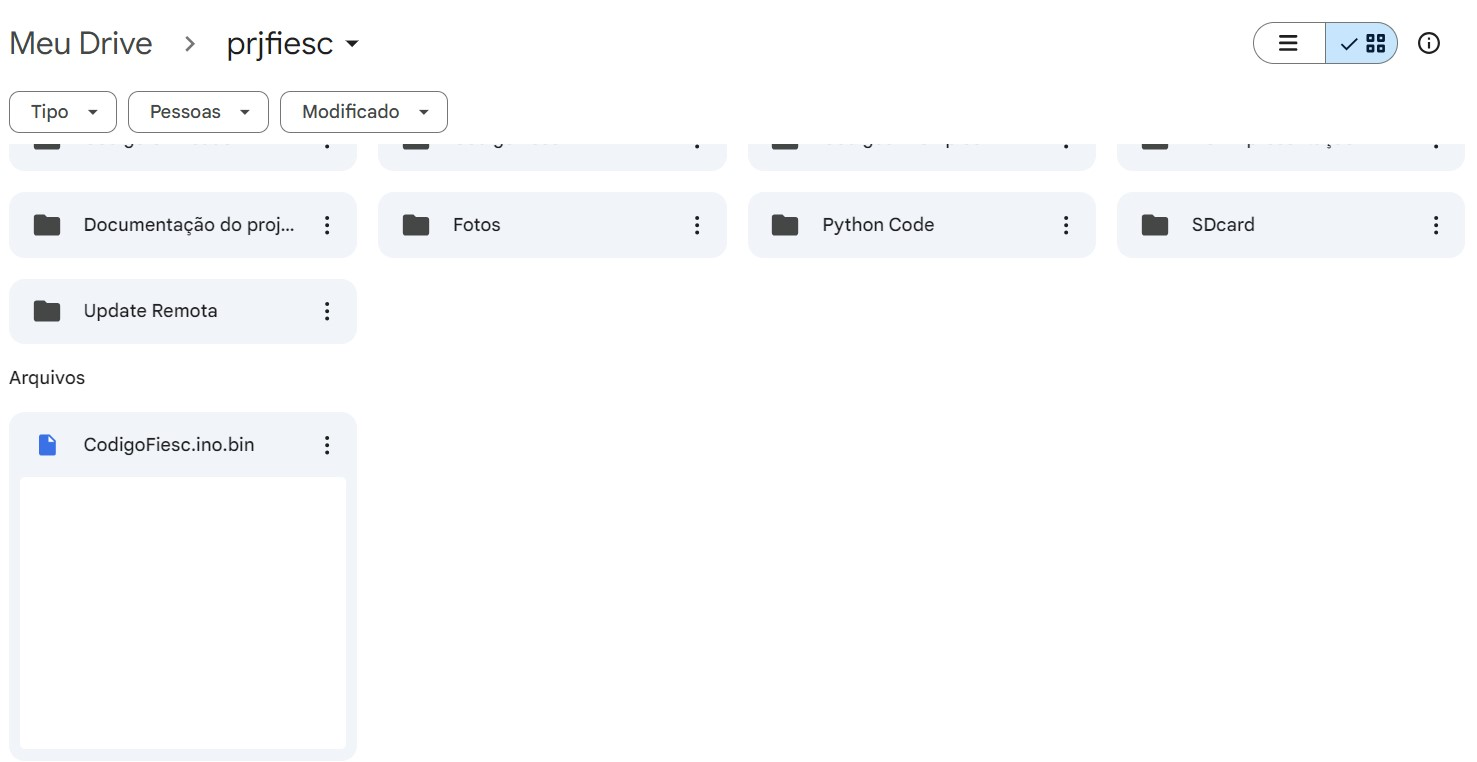

In [94]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "Firdrive.jpg", width=800, height=800)

## Escrevendo dados no MQTT

In [ ]:
import tkinter as tk
from tkinter import messagebox
import paho.mqtt.client as mqtt
import random

# Configurações do broker MQTT
broker = 'broker.emqx.io'
port = 1883
topic = "redefrigo/tpms_control"
client_id = f'python-mqtt-{random.randint(0, 100)}'
username = 'emqx'
password = 'public'

# Função para enviar a mensagem selecionada
def send_message():
    selected_message = message_var.get()
    if selected_message:
        client.publish(topic, selected_message)
        messagebox.showinfo("Mensagem Enviada", f"Mensagem enviada: {selected_message}")
    else:
        messagebox.showwarning("Selecione uma Mensagem", "Por favor, selecione uma mensagem para enviar.")

# Configurações do cliente MQTT
client = mqtt.Client(client_id)
client.username_pw_set(username, password)

# Conectar ao broker MQTT
try:
    client.connect(broker, port, 60)
except Exception as e:
    print(f"Erro ao conectar ao broker: {e}")

# Criação da interface gráfica
root = tk.Tk()
root.title("Envio de Mensagens MQTT")

# Variável para armazenar a mensagem selecionada
message_var = tk.StringVar()

# Lista de mensagens
messages = [
    "Calibrar pneus",
    "Parar de roldar",
    "Caminhão desligado devido a ingerir álcool",
    "Limite de horas dirigindo excedido"
]

# Criação do menu de seleção
message_label = tk.Label(root, text="Selecione uma Mensagem:")
message_label.pack(pady=10)

for msg in messages:
    rb = tk.Radiobutton(root, text=msg, variable=message_var, value=msg)
    rb.pack(anchor=tk.W)

# Botão para enviar a mensagem
send_button = tk.Button(root, text="Enviar", command=send_message)
send_button.pack(pady=20)

# Loop principal da interface
root.mainloop()

# Desconectar ao sair
client.disconnect()


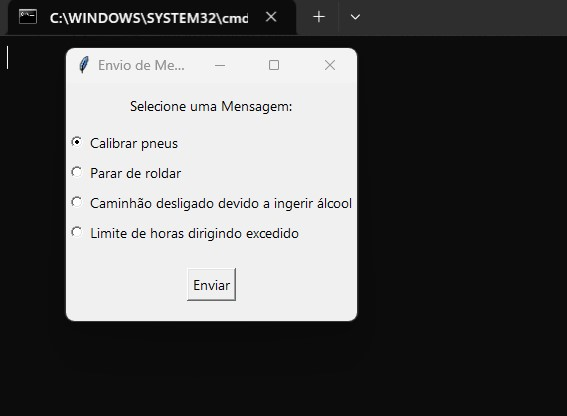

In [101]:
from IPython.display import Image
PATH = "G:Meu Drive/prjfiesc/Fotos/"
Image(filename = PATH + "InformMot.jpg", width=400, height=400)

In [2]:
n = 4 
print n


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (2128246435.py, line 2)